In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models

from data_utils.utils import keep_existing_photos, preprocess_image, display_pseudolabels_based_on_confidence
from data_utils.dataset import PhotoLabelDataset, val_transform
from model.utils import get_device

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)
top_reviews_per_restaurant = pd.read_csv(f'{base_dir}data/yelp_dataset/top_reviews_per_restaurant_with_summary.csv')

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes', 'categories']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace({2: 1, 3: 2, 4: 2}) 

food_with_reviews_df = photos_df.merge(top_reviews_per_restaurant, on="business_id", how="left")

Checking images: 100%|██████████| 200100/200100 [00:04<00:00, 41062.81it/s]


In [17]:
device = get_device()
model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 101)  # 101 food classes
)

ckpt = torch.load(f"{base_dir}saved_models/food101/ckpt_best")
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
label = 'price_range'

dataset = PhotoLabelDataset(food_with_reviews_df, photo_dir, label, transform=val_transform)

batch_size = 64

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [19]:
all_predictions = []
all_confidences = []

with torch.no_grad():
    for batch in loader:
        images, _ = batch
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1) 
        predictions = torch.argmax(probs, dim=1)
        confidences = torch.max(probs, dim=1).values

        all_predictions.append(predictions.cpu())
        all_confidences.append(confidences.cpu())

final_predictions = torch.cat(all_predictions, dim=0)
final_confidences = torch.cat(all_confidences, dim=0)

In [20]:
photos_df['food101_predictions'] = final_predictions
photos_df['food101_confidences'] = final_confidences

In [4]:
class_mapping = {}
with open(f'{base_dir}/data/food101/food-101/meta/classes.txt', 'r') as file:
    classes = file.read().splitlines()
    for index, class_name in enumerate(classes):
        class_mapping[index] = class_name

In [22]:
photos_df['food101_predictions_decoded'] = photos_df['food101_predictions'].apply(lambda x: class_mapping[x])

In [5]:
photos_df.to_csv(f'{base_dir}data/photos_df_with_food101_predictions.csv', index=False, encoding="utf-8")

In [3]:
photos_df_with_food101 = pd.read_csv(f'{base_dir}data/photos_df_with_food101_predictions.csv', engine="python")

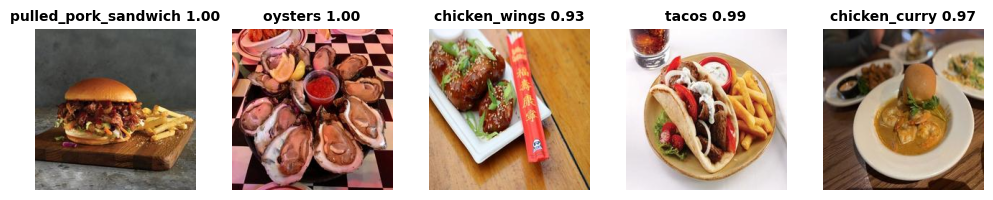

In [18]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0.9, max_conf=1, image_dir=photo_dir)

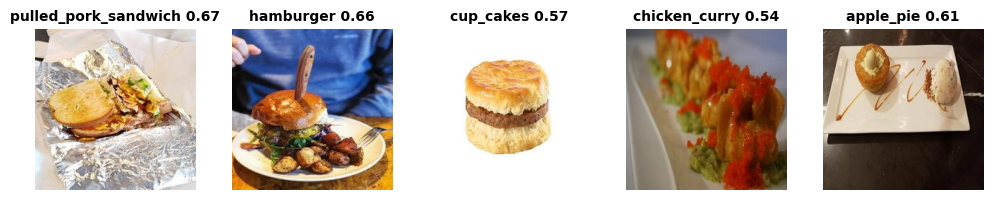

In [6]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0.5, max_conf=0.8, image_dir=photo_dir)

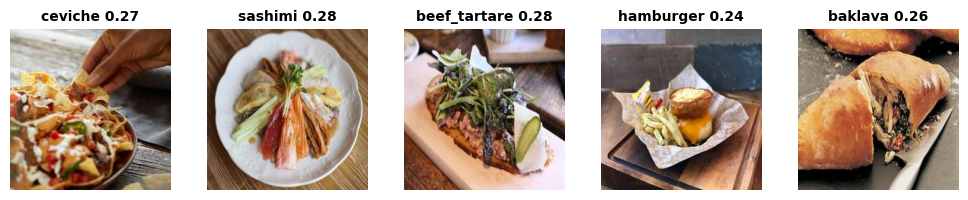

In [9]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0, max_conf=0.3, image_dir=photo_dir)

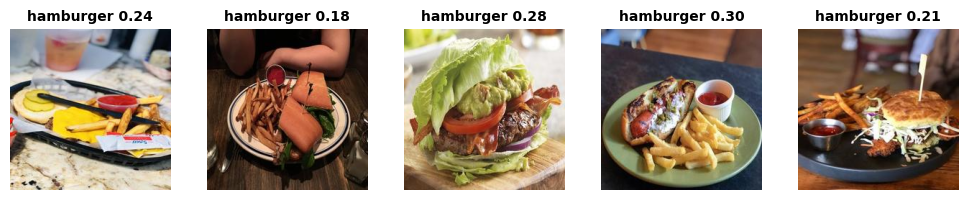

In [41]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0, max_conf=0.3, image_dir=photo_dir, food_label='hamburger')

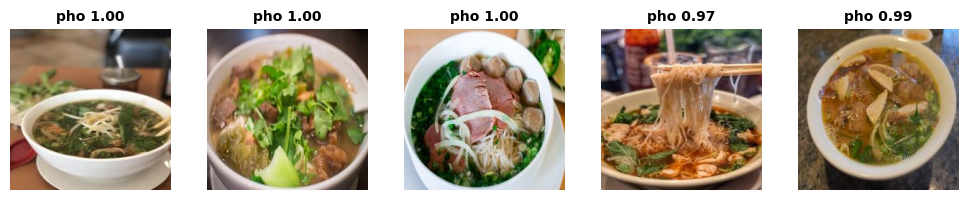

In [51]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0.9, max_conf=1, image_dir=photo_dir, food_label='pho')

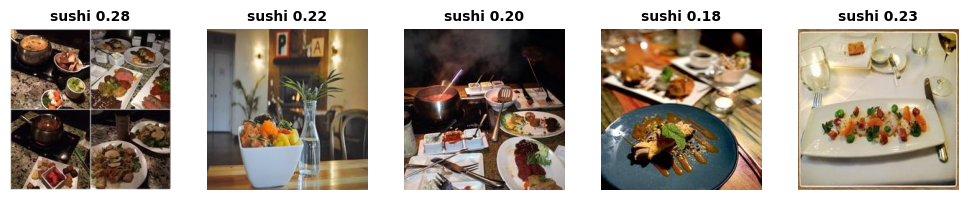

In [50]:
display_pseudolabels_based_on_confidence(photos_df_with_food101, min_conf=0, max_conf=0.3, image_dir=photo_dir, food_label='sushi')

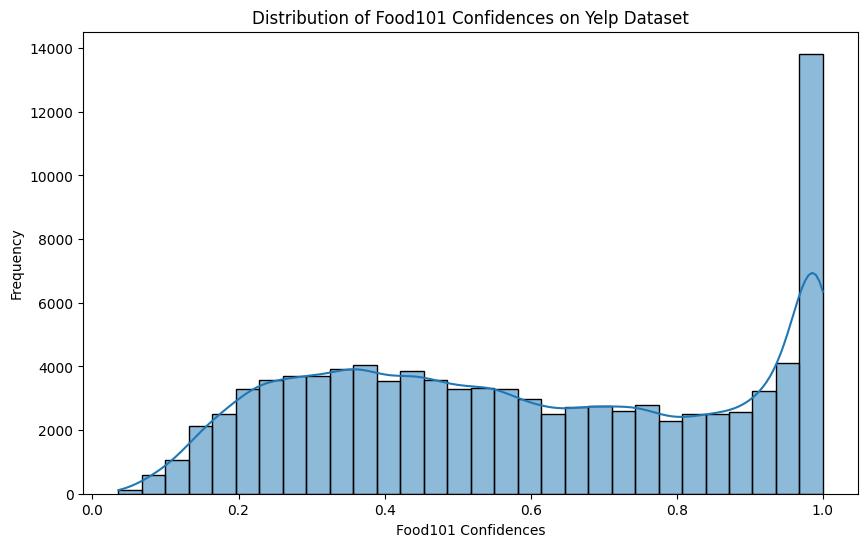

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(photos_df_with_food101['food101_confidences'], bins=30, kde=True)
plt.title('Distribution of Food101 Confidences on Yelp Dataset')
plt.xlabel('Food101 Confidences')
plt.ylabel('Frequency')
plt.show()

In [21]:
number_above_90 = len(photos_df_with_food101[(photos_df_with_food101.food101_confidences >= 0.9) & 
                           (photos_df_with_food101.food101_confidences <= 1)])
total_number = len(photos_df_with_food101)
print("Number of pseudolabels with above 0.9 confidence: ", number_above_90)
print("Total number of photos: ", total_number)
print("Proportion of above 0.9 confidence labels: ", number_above_90 / total_number)

Number of pseudolabels with above 0.9 confidence:  21462
Total number of photos:  96975
Proportion of above 0.9 confidence labels:  0.22131477184841453
